In [1]:
import numpy as np
from tqdm import tqdm
from PIL import Image
# from openTSNE import TSNE
import matplotlib.pyplot as plt
import copy
# import pandas as pd
# import seaborn as sns
import random

import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

# 使用正负置信度进行降维
from AE import Mydata_sets2
import model_files as model_all
device = torch.device("cuda:0")
dataset_type = "GTSRB"
model_name = "ResNet18"



In [ ]:
ResNet18 = model_all.get_DNN_model(dataset_type, model_name)
ResNet18.load_state_dict( torch.load("./model_files/GTSRB/checkpoints/classify_model/ResNet18.pth", map_location=device)['model']) # 这个pt文件里不仅仅是参数，包括了模型
# ResNet50 = torch.load("./model_files/CIFAR10/checkpoints/classify_model/ResNet50.pt", map_location=device)
ResNet18 = ResNet18.to(device)
ResNet18.eval()


# feature_model = copy.deepcopy(ResNet18)
# feature_model.fc = nn.Identity() # 相当于取消fc层, 这样


# checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth"  # kjl测试#############
global G
print("数据类型为：", dataset_type)
G = model_all.get_generative_model("GTSRB").to(device)
G.load_state_dict(torch.load('GTRSB/GTSRB_cDCGAN_results/GTSRB_cDCGAN_generator_param_size32_epoch20.pth'))
G.eval()

data_z_path = "./static/data/GTSRB/latent_z/cGAN_100z_size32_50k.pt"
label_path = "./static/data/GTSRB/labels/cGAN_label_size32_50k.pt"
dict_zs = torch.load(data_z_path, map_location="cpu")  # 因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错
data_z_labels = torch.load(label_path,map_location="cpu")

zs_datasets = Mydata_sets2(dict_zs,data_z_labels)
    # 不需要前向传播，一次可以多处理一些
zs_loader = DataLoader(zs_datasets, batch_size=32, shuffle=False, num_workers=0)  # 指定读取配置信息


features, labels, max_values, ids, ten_Ds, picture = [], [], [], [], [], [] # features：提取的2048维图片特征，labels：模型预测的标签，ids图片文件编号
# 每个类别的onehot
onehot = torch.zeros(43, 43)
onehot = onehot.scatter_(1, torch.LongTensor(list(range(43))).view(43, 1), 1).view(43,43, 1, 1)


with torch.no_grad():  # 取消梯度计算，加快运行速度
    for batch_z, batch_labels in zs_loader:
        # z = torch.tensor(batch_z, dtype=torch.float32, device=device).detach()
        label_onehot = onehot[batch_labels]
        batch_z = batch_z.to(device)
        # z = torch.tensor(batch_z).to(torch.float32).to(device).detach()  # latent code
        imgs = G(batch_z,label_onehot.to(device))

        # feature = feature_model(imgs)  # N, 2048
        # features.append(feature)
        # DNN_model.layer3.register_forward_hook(get_activation('layer3'))
        layers = ResNet18(imgs)  # 分类模型分类图片
        # CAMlayer = activation['layer3']
        max_value, label = torch.max(layers, dim=1)
        same_labels_mask = torch.eq(label, batch_labels.to(device))
        # 将不同标签对应的置信度设为负值
        max_value = torch.where(same_labels_mask, max_value, -max_value)
        picture.append(imgs)
        # label = torch.argmax(ten_D, dim=1)
        ten_Ds.append(layers)
        labels.append(label)
        max_values.append(max_value)

picture = torch.cat(picture, dim=0).squeeze().view(50000,-1).cpu().numpy()
ten_Ds = torch.cat(ten_Ds, dim=0).squeeze().cpu().numpy()  # (n, 10)
# features = torch.cat(features, dim=0).squeeze().cpu().numpy()  # (n, 2048)
labels = torch.cat(labels, dim=0).squeeze().cpu().numpy()  # n
max_values = torch.cat(max_values, dim=0).squeeze().cpu().numpy()  # n

In [5]:
# 保存numpy数组到文件
np.save('./temp/pic/AE_GTSRB_conf+-/labels.npy', labels)
np.save('./temp/pic/AE_GTSRB_conf+-/max_values.npy', max_values)
np.save('./temp/pic/AE_GTSRB_conf+-/ten_feature.npy', ten_Ds)
np.save('./temp/pic/AE_GTSRB_conf+-/picture.npy', picture)

In [2]:
from torch import optim
from AE import AutoencoderWithAttributeLoss2, CustomLoss2, Mydata_sets1
import numpy as np

loaded_labels = np.load('./temp/pic/AE_GTSRB_conf+-/labels.npy')
loaded_max_values = np.load('./temp/pic/AE_GTSRB_conf+-/max_values.npy')
loaded_ten = np.load('./temp/pic/AE_GTSRB_conf+-/ten_feature.npy')
picture = np.load('./temp/pic/AE_GTSRB_conf+-/picture.npy')
label_path = "./static/data/GTSRB/labels/cGAN_label_size32_50k.pt"
data_z_labels = torch.load(label_path,map_location="cpu")
data_z_labels = data_z_labels.to(device)
print(data_z_labels.shape)
min_value = np.min(loaded_max_values)
sorted_values = np.sort(loaded_max_values)

# 初始化等级数组
level_array = np.zeros_like(loaded_max_values, dtype=int)

num_samples = len(loaded_max_values)
num_intervals = 10
samples_per_interval = num_samples // num_intervals
thresholds = [sorted_values[i * samples_per_interval] for i in range(1, num_intervals)]

# 考虑最小值，确保每个区间都包含最小值
thresholds = [min_value] + thresholds

# 根据阈值将样本划分到对应的区间
for i, threshold in enumerate(thresholds[:-1]):
    level_array[(loaded_max_values >= threshold) & (loaded_max_values < thresholds[i+1])] = i

# 最后一个区间的样本划分为最大值的区间
level_array[loaded_max_values >= thresholds[-1]] = num_intervals - 1
input_data = torch.tensor(loaded_ten, dtype=torch.float32).to(device)
print(input_data.shape)
confidence = torch.tensor(level_array, dtype=torch.float32).to(device)
print(confidence.shape)

torch.Size([50000])
torch.Size([50000, 43])
torch.Size([50000])


In [9]:

# checkpoint = torch.load('./temp/pic/AE_GTSRB_conf+-/autoencoder_checkpoint.pth')
autoencoder = AutoencoderWithAttributeLoss2(input_dim=input_data.shape[1], encoding_dim=43).to(device)
# autoencoder.load_state_dict(checkpoint['model_state_dict'])

criterion = CustomLoss2()

# 设置优化器
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# 恢复优化器状态
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 恢复调度器状态
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
autoencoder.train()
# start_epoch = checkpoint['epoch'] + 1
start_epoch = 0
# 训练模型
num_epochs = 200
batch_size = 128
for epoch in range(start_epoch,start_epoch+num_epochs):
    for i in range(0, len(input_data), batch_size):
        optimizer.zero_grad()
        batch_input = input_data[i:i+batch_size]
        batch_confidence = confidence[i:i+batch_size]
        batch_labels = data_z_labels[i:i+batch_size]

        attribute_output, attribute_output2, reconstructed = autoencoder(batch_input)
        batch_confidence = batch_confidence.long()
        batch_labels = batch_labels.long()
        loss, recon_loss, attribute_loss, attribute_loss2 = criterion(reconstructed, batch_input, attribute_output, batch_confidence, attribute_output2, batch_labels)
        # loss = criterion(reconstructed, batch_input, attribute_output, batch_confidence)
        loss.backward()
        optimizer.step()
    scheduler.step()  # 更新学习率


    print(f"Epoch {epoch+1}, Loss: {loss.item()},Reconstruction Loss: {recon_loss.item()}, Attribute Loss: {attribute_loss.item()}, Attribute Loss2: {attribute_loss2.item()}")


Epoch 1, Loss: 6.376163482666016,Reconstruction Loss: 8.841879844665527, Attribute Loss: 1.501598596572876, Attribute Loss2: 0.45362454652786255
Epoch 2, Loss: 6.21275520324707,Reconstruction Loss: 8.838315963745117, Attribute Loss: 1.3665071725845337, Attribute Loss2: 0.4270903468132019
Epoch 3, Loss: 6.077268123626709,Reconstruction Loss: 8.837215423583984, Attribute Loss: 1.3029634952545166, Attribute Loss2: 0.3556971549987793
Epoch 4, Loss: 5.998835563659668,Reconstruction Loss: 8.788066864013672, Attribute Loss: 1.3034355640411377, Attribute Loss2: 0.30136680603027344
Epoch 5, Loss: 5.89159631729126,Reconstruction Loss: 8.767144203186035, Attribute Loss: 1.2540924549102783, Attribute Loss2: 0.25393146276474
Epoch 6, Loss: 5.8153533935546875,Reconstruction Loss: 8.743380546569824, Attribute Loss: 1.2142393589019775, Attribute Loss2: 0.22942356765270233
Epoch 7, Loss: 5.833770751953125,Reconstruction Loss: 8.739545822143555, Attribute Loss: 1.20785653591156, Attribute Loss2: 0.25614

In [10]:
# torch.save(autoencoder.state_dict(), './temp/pic/AE_GTSRB_conf+-/autoencoder_model.pth')
import torch

# 假设你的优化器是optimizer，学习率调度器是scheduler
torch.save({
    'epoch': num_epochs,
    'model_state_dict': autoencoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': loss,
}, './temp/pic/AE_GTSRB_conf+-/autoencoder_checkpoint_add3loss.pth')

In [12]:
import matplotlib.pyplot as plt
from openTSNE import TSNE
import torch.nn.functional as F

loaded_autoencoder = AutoencoderWithAttributeLoss2(input_dim=input_data.shape[1], encoding_dim=43).to(device)
# loaded_autoencoder.load_state_dict(torch.load('./temp/pic/AE/autoencoder_model_use_image.pth'))

# 加载保存的检查点
checkpoint = torch.load('./temp/pic/AE_GTSRB_conf+-/autoencoder_checkpoint_add3loss.pth')

# 恢复模型状态
loaded_autoencoder.load_state_dict(checkpoint['model_state_dict'])
loaded_autoencoder.eval()




with torch.no_grad():
    encoded_output = loaded_autoencoder.encoder(input_data)
print(encoded_output.shape)
# encoded_output = F.normalize(encoded_output, p=2, dim=1)
# print(encoded_output[:5])


torch.Size([50000, 16])


In [13]:
import pandas as pd

embed = TSNE(n_jobs=4).fit(encoded_output.cpu())  # N, 2
pd_embed = pd.DataFrame(embed)
print(pd_embed.shape)

np.save('./temp/pic/AE_GTSRB_conf+-/embed_2dim.npy', pd_embed)


(50000, 2)


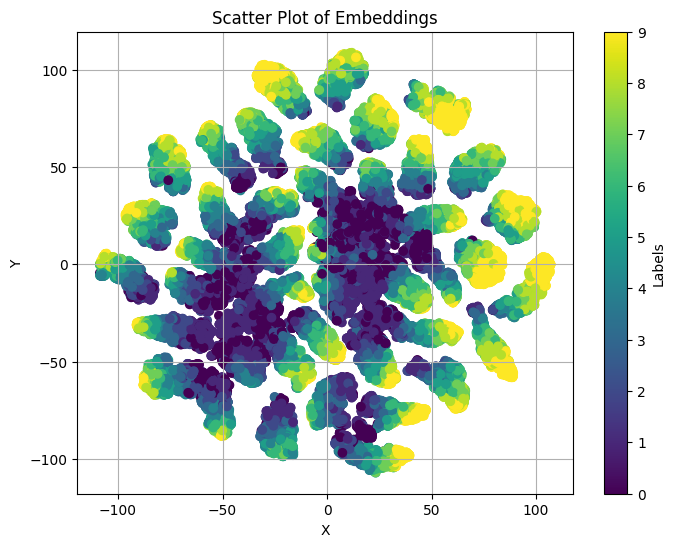

In [5]:
import pandas as pd
pd_embed = np.load('./temp/pic/AE_GTSRB_conf+-/embed_2dim.npy')
pd_embed = pd.DataFrame(pd_embed)
x = pd_embed.iloc[:, 0]
y = pd_embed.iloc[:, 1]
# loaded_labels = np.load('./temp/pic/AE/labels.npy')
label_path = "./static/data/GTSRB/labels/cGAN_label_size32_50k.pt"
data_z_labels = torch.load(label_path,map_location="cpu")
data_z_labels = data_z_labels.to(device)
data_z_labels = data_z_labels.cpu()
# 绘制二维散点图
plt.figure(figsize=(8, 6))
# plt.scatter(x, y, c=data_z_labels, cmap='viridis')
plt.scatter(x, y, c=level_array, cmap='viridis')
plt.colorbar(label='Labels')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Embeddings')
plt.grid(True)
plt.show()

In [18]:

from scipy import spatial
pd_embed = np.load('./temp/pic/AE_GTSRB_conf+-/embed_2dim.npy')

print(pd_embed[:5])

# 找到每个维度的最小值和最大值
min_x, min_y = np.min(pd_embed, axis=0)
max_x, max_y = np.max(pd_embed, axis=0)

# 缩放坐标到0到1的范围内
scaled_value = (pd_embed - [min_x, min_y]) / [max_x - min_x, max_y - min_y]

print("Scaled Coordinates:\n", scaled_value[:5])

tree = spatial.KDTree(data=scaled_value)

# torch.save(tree, "./static/data/CIFAR10/2D_kdTree/2D_kdTree_50000_png_2024-3-25.pt")
torch.save(tree, "./static/data/GTSRB/2D_kdTree/2D_kdTree_50000_png_AE_add3loss.pt")


[[  8.40912588  -8.4170368 ]
 [  3.05800395  51.55861239]
 [ 30.32222222  77.25725751]
 [  6.41090975  -1.25054317]
 [-16.00254758  14.05026198]]
Scaled Coordinates:
 [[0.54290546 0.45730069]
 [0.51809935 0.73500729]
 [0.64448765 0.85400031]
 [0.53364237 0.49048387]
 [0.42974066 0.56133153]]
